# Решение тестового задания по Speech Enhancement

### **TL;DR**

В работе реализована **модифицированная версия MP-SENet**, в которой классические **Transformer-блоки** заменены на **параллельное сочетание Transformer и Mamba-блоков** (из библиотеки `mamba-ssm`).
Обе ветви (**Transformer** и **Mamba**) обрабатывают признаки независимо, после чего их выходы **объединяются с помощью cross-attention** (подробнее можно посмотреть в коде проекта `MP-SENet/models/model.py`).

Модель обучалась на **VoiceBank+DEMAND (16 kHz)** и демонстрирует хорошие метрики улучшения качества речи (**PESQ 3.44 на VoiceBank+DEMAND**).
Ниже приведён гайд (полный пайплайн) по настройке проекта, воспроизведению обучения модели, а также анализ и сравнение полученных результатов. 

---


## **0. Настройка окружения**

### **Требования**

* Linux
* NVIDIA GPU
* CUDA 11.6 или выше
* Python 3.8 (можно выше, но на свой страх и риск)

Создайте окружение `mp-senet` с помощью `conda`:

```bash
cd MP-SENet   # Датасет скачивается туда же
conda create -n mp-senet python=3.8
conda activate mp-senet
pip install -r requirements.txt
```

Также убедитесь, что устанавливаете совместимую версию `torch` (могут быть конфликты версий CUDA с mamba-ssm), я запускал 2.4.1 с CUDA 12.1:

```bash
pip install torch==2.4.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121
```


## **1. Скачивание датасета** (для воспроизводимости обучения / проверки модели)

#### Можно скачать вручную [по ссылке](https://drive.google.com/drive/folders/19I_thf6F396y5gZxLTxYIojZXC0Ywm8l) или через CLI:

In [ ]:
!pip install gdown

from google.colab import drive
drive.mount('/content/drive')

!gdown --folder --id 19I_thf6F396y5gZxLTxYIojZXC0Ywm8l -q
!unzip -q "VoiceBank+DEMAND/*.zip" -d "VoiceBank+DEMAND/"

#### **Примечание**: важно, чтобы данные скачались и распаковались в директорию MP-SENet, с кодом репозитория исходной модели

## **2. Запуск обучения**
#### В данном ноутбуке запускать обучение нет смысла (так как занимает много времени), я проделал это отдельным процессом в терминале (рекомендую запускать именно в терминале, так как в jupyter notebook могут быть проблемы с многопоточкой) и сохранил чекпоинты обученной модели в `MP-SENet/best_ckpt`.

In [ ]:
!python train.py --config config.json --input_clean_wavs_dir 'VoiceBank+DEMAND/wav_clean' --input_noisy_wavs_dir 'VoiceBank+DEMAND/wav_noisy' --training_epochs 20 --checkpoint_interval 1000 --stdout_interval 10

## **3. Валидация**
#### Для начала соберем датасеты, состоящие только из тестовых данных и запустим на них инференс:

In [3]:
%cd MP-SENet

/mnt/c/Users/szabu/PycharmProjects/VK_entry_test/MP-SENet


In [7]:
from pathlib import Path
import shutil
from typing import Iterable

def copy_split(
    dataset_dir: Path,
    src_subdir: str,
    list_file: str,
    dst_subdir: str,
    *,
    idx: int = 0,
    sep: str = "|",
    ext: str = ".wav",
):
    src = dataset_dir / src_subdir
    dst = dataset_dir / dst_subdir
    dst.mkdir(parents=True, exist_ok=True)

    lines = (dataset_dir / list_file).read_text(encoding="utf-8").splitlines()

    names = {line.strip().split(sep)[idx] + ext for line in lines if line.strip()}
    copied: list[str] = []
    missing: list[str] = []

    for name in sorted(names):
        src_path = src / name
        if src_path.exists():
            shutil.copy2(src_path, dst)
            copied.append(name)
            #print(f"added {name}")
        else:
            missing.append(name)
            print(f"File not found: {src_path}")

    print(f"\nDone: {len(copied)} copied, {len(missing)} missing -> {dst}")

dataset = Path("VoiceBank+DEMAND")

copy_split(
    dataset_dir=dataset,
    src_subdir="wav_noisy",
    list_file="test.txt",
    dst_subdir="testset_noisy",
)

copy_split(
    dataset_dir=dataset,
    src_subdir="wav_clean",
    list_file="test.txt",
    dst_subdir="testset_clean",
)


Done: 824 copied, 0 missing → VoiceBank+DEMAND/testset_noisy

Done: 824 copied, 0 missing → VoiceBank+DEMAND/testset_clean


In [8]:
!python inference.py --checkpoint_file "best_ckpt/best_model" --input_noisy_wavs_dir "VoiceBank+DEMAND/testset_noisy" --output_dir "VoiceBank+DEMAND/generated_files"

/home/alex/miniconda3/envs/mp-senet/lib/python3.8/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/home/alex/miniconda3/envs/mp-senet/lib/python3.8/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/home/alex/miniconda3/envs/mp-senet/lib/python3.8/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/alex/miniconda3/envs/mp-senet/lib/python3.8/site-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cud

### Оценим метрики на тесте скриптом из оригинального репозитория MP-SENet:

In [9]:
!python cal_metrics/cal_metrics_vb.py --clean_wav_dir "VoiceBank+DEMAND/testset_clean" --noisy_wav_dir "VoiceBank+DEMAND/generated_files"

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:04:0600:0100:06
pesq:  3.4432880301209328 csig:  4.731125951193228 cbak:  3.9277886146733727 covl:  4.198151213161301 ssnr:  10.671344326910742 stoi:  0.9587752427405878


## 4. Примеры аудио до и после обработки (+ спектрограммы):

{'text/plain': '[1] p232_001.wav'}

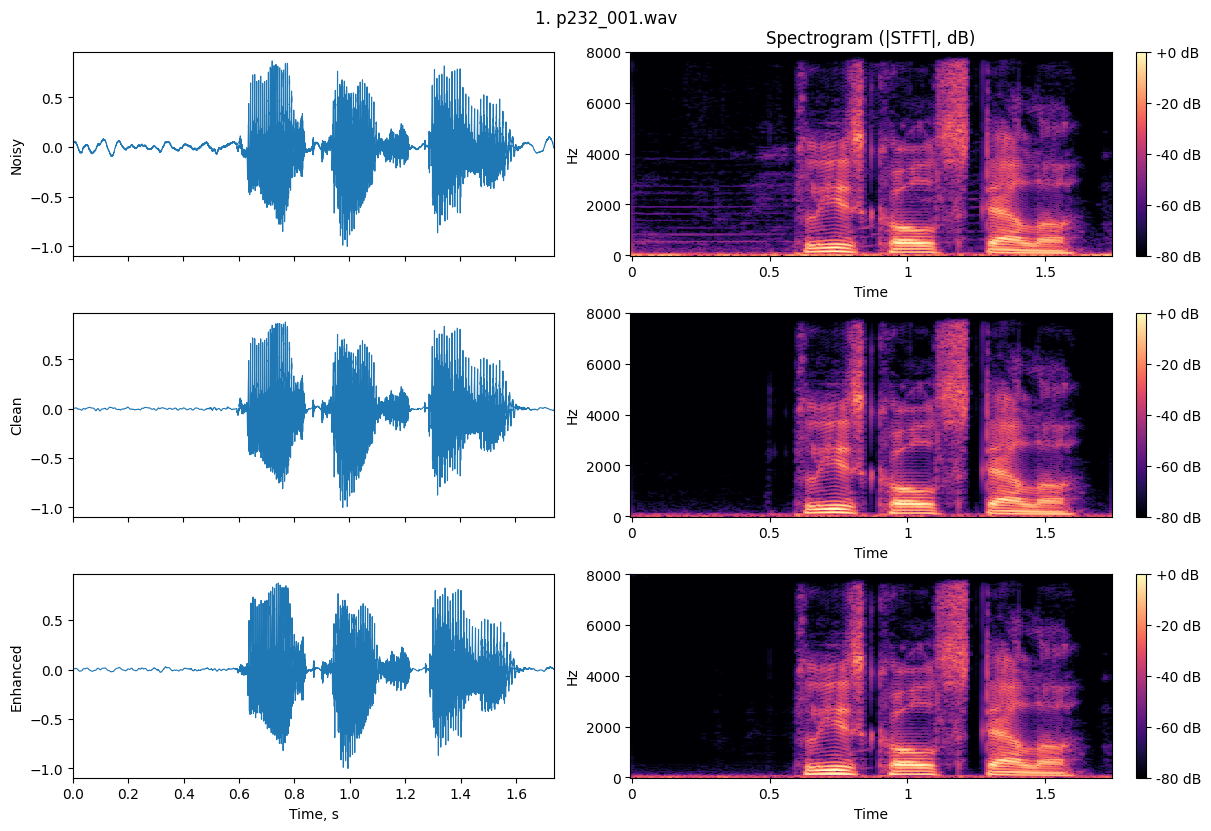

{'text/plain': '[2] p232_002.wav'}

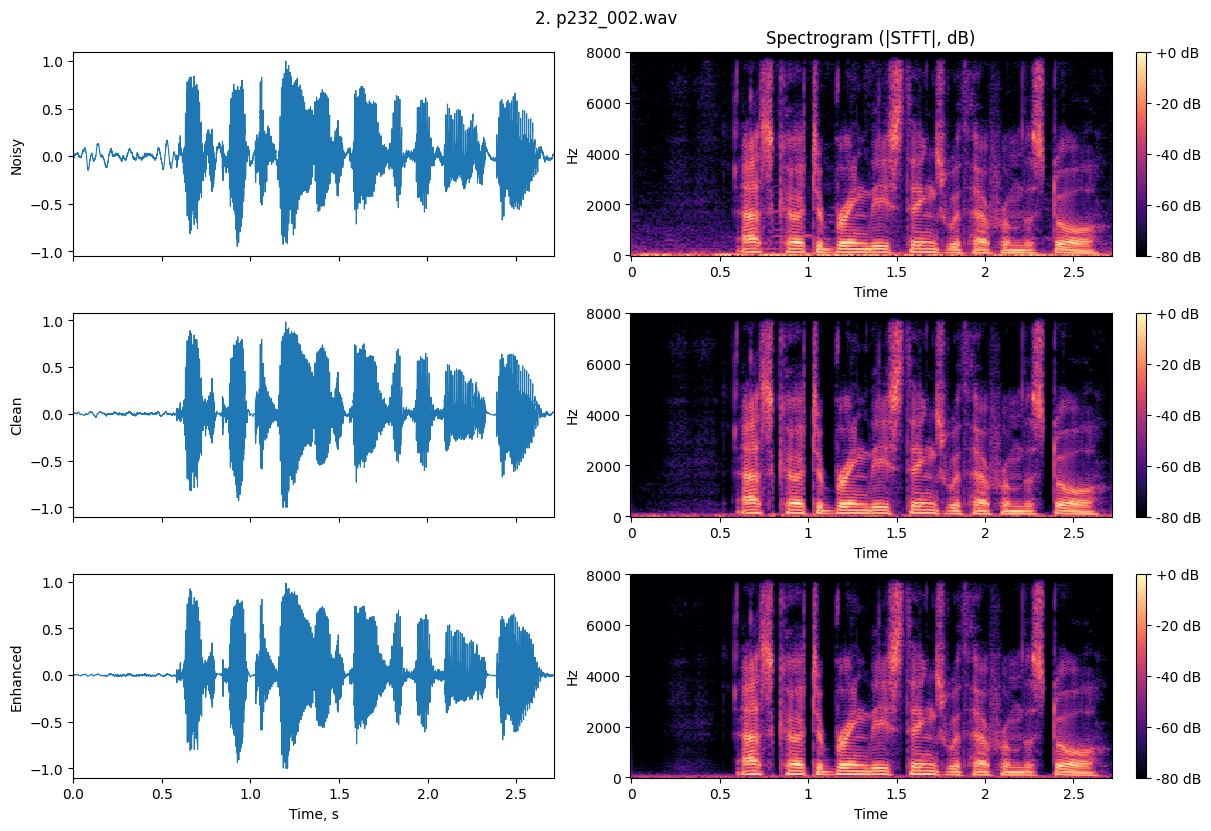

{'text/plain': '[3] p232_003.wav'}

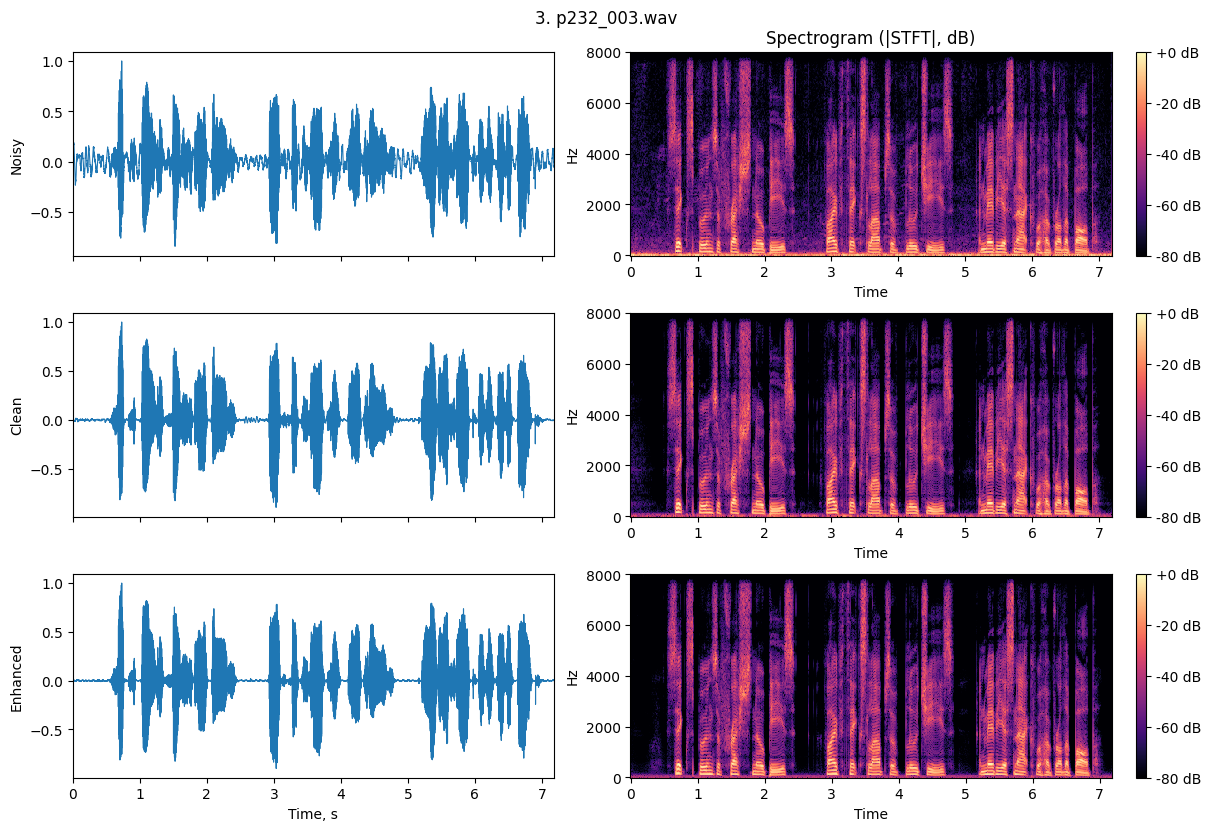

{'text/plain': '[4] p232_005.wav'}

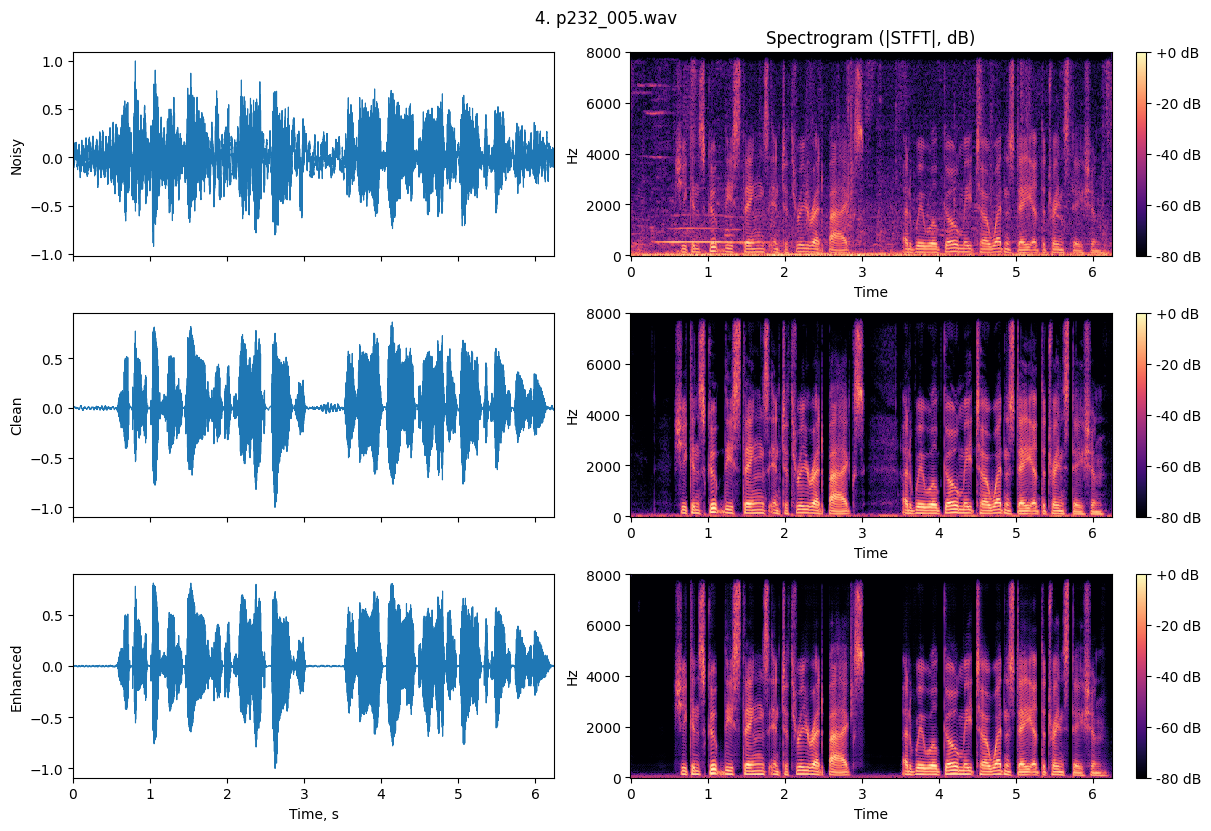

{'text/plain': '[5] p232_006.wav'}

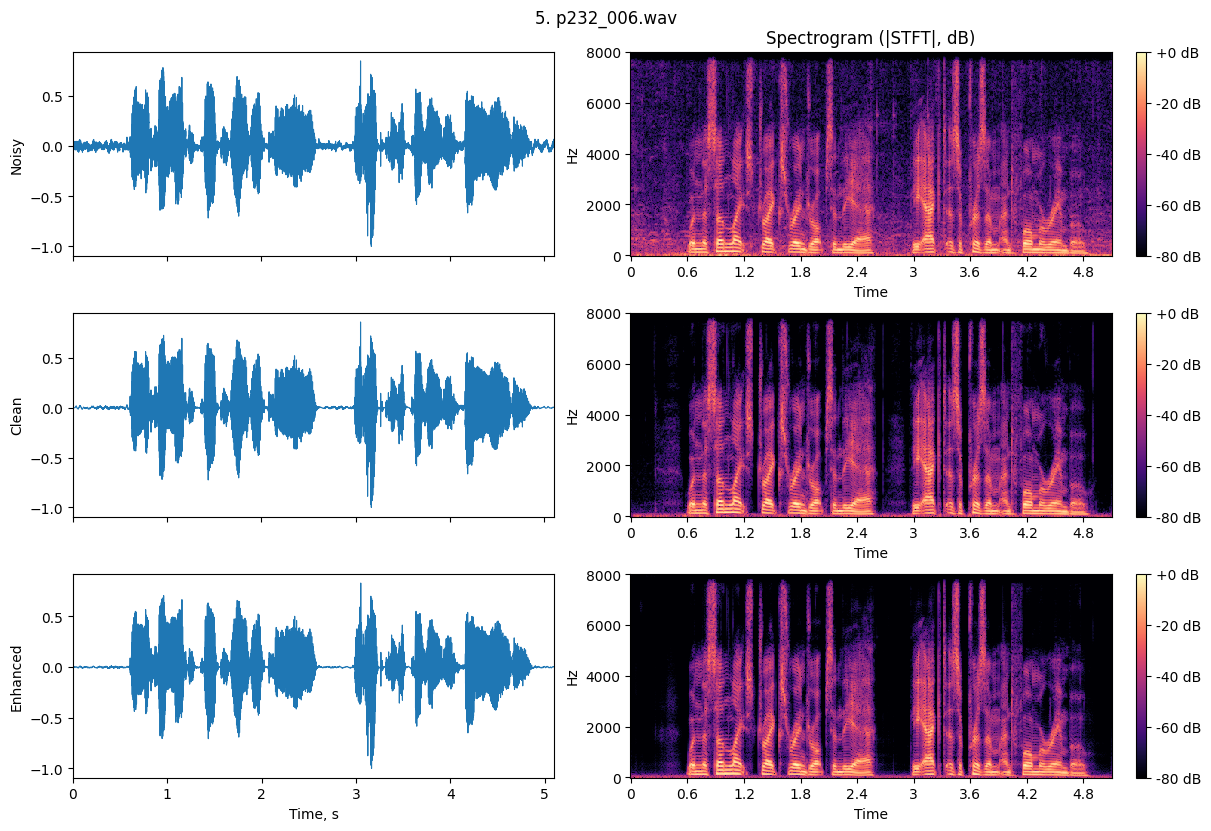

In [1]:
from pathlib import Path
from typing import List, Tuple
import numpy as np
import librosa
import librosa.display as lbd
import matplotlib.pyplot as plt
from IPython.display import Audio, display

clean_dir     = Path("MP-SENet/VoiceBank+DEMAND/testset_clean")
noisy_dir     = Path("MP-SENet/VoiceBank+DEMAND/testset_noisy")
enhanced_dir  = Path("MP-SENet/VoiceBank+DEMAND/generated_files")
N             = 5
sr            = 16_000
n_fft   = 512
hop_len = 128
win_len = 512

def load_mono_16k(path: Path, sr: int) -> np.ndarray:
    y, _ = librosa.load(str(path), sr=sr, mono=True)
    m = np.max(np.abs(y)) if y.size else 1.0
    if m > 0:
        y = y / max(m, 1e-9)
    return y.astype(np.float32)

def stft_db(y: np.ndarray) -> np.ndarray:
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_len, win_length=win_len)) + 1e-9
    return librosa.amplitude_to_db(S, ref=np.max)

def match_triplets(clean_dir: Path, noisy_dir: Path, enhanced_dir: Path) -> List[Tuple[Path, Path, Path]]:
    clean_map = {p.name: p for p in clean_dir.glob("*.wav")}
    noisy_map = {p.name: p for p in noisy_dir.glob("*.wav")}
    enh_map   = {p.name: p for p in enhanced_dir.glob("*.wav")}

    common = sorted(set(clean_map) & set(noisy_map))
    triplets = []
    for name in common:
        enh = enh_map.get(name, None)
        if enh is None:
            continue
        triplets.append((clean_map[name], noisy_map[name], enh))
    return triplets

def plot_sample(noisy_y, clean_y, enh_y, sr, title):
    fig, axes = plt.subplots(3, 2, figsize=(12, 8), constrained_layout=True)
    rows = [("Noisy", noisy_y), ("Clean", clean_y), ("Enhanced", enh_y)]

    for r, (label, y) in enumerate(rows):
        # Волна
        t = np.arange(len(y)) / sr
        ax_w = axes[r, 0]
        ax_w.plot(t, y, linewidth=0.8)
        ax_w.set_xlim(0, t[-1] if len(t) else 1)
        ax_w.set_ylabel(label)
        if r == 2:
            ax_w.set_xlabel("Time, s")
        else:
            ax_w.set_xticklabels([])

        # Спектр
        ax_s = axes[r, 1]
        Sdb = stft_db(y)
        img = lbd.specshow(Sdb, sr=sr, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax_s)
        if r == 0:
            ax_s.set_title("Spectrogram (|STFT|, dB)")
        fig.colorbar(img, ax=ax_s, format="%+2.0f dB")

    fig.suptitle(title, y=1.02)
    plt.show()

triplets = match_triplets(clean_dir, noisy_dir, enhanced_dir)
if not triplets:
    raise SystemExit("Не удалось подобрать совпадающие тройки файлов. Проверьте директории.")

for i, (clean_p, noisy_p, enh_p) in enumerate(triplets[:N], start=1):
    # грузим
    clean_y   = load_mono_16k(clean_p, sr)
    noisy_y   = load_mono_16k(noisy_p, sr)
    enhanced_y= load_mono_16k(enh_p, sr)

    # аудиоплееры (сначала заголовок, затем три плеера)
    display({"text/plain": f"[{i}] {noisy_p.name}"})
    display(
        Audio(noisy_y, rate=sr),
    )
    display(
        Audio(clean_y, rate=sr),
    )
    display(
        Audio(enhanced_y, rate=sr),
    )

    title = f"{i}. {noisy_p.name}"
    plot_sample(noisy_y, clean_y, enhanced_y, sr, title)


## Теперь проверим на метриках из URGENT.
#### Примечание: Intrusive метрики (pesq, stoi) были посчитаны выше, поэтому здесь они не считались. Также, так как часть метрик вычислительно сложные и не слишком актуальны для данного (и так объемного) задания (intrusive/non-intrusive downstream task metrics), они здесь тоже не считались. Реализация подсчета остальных метрик из URGENT приведена ниже.

In [2]:
# Рекомендую настроить отдельную среду под метрики (в URGENT вообще советуют pip даунгрейднуть до 24.0, чтобы часть библиотек нормально грузилась)

import os
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"] = "1"

import os
from pathlib import Path
import json

import numpy as np
import torch
import librosa

from tqdm.auto import tqdm

# Cобственно метрики
import utmos
from speechmos import dnsmos
from torchmetrics.audio.nisqa import NonIntrusiveSpeechQualityAssessment
from scoreq import Scoreq

/home/alex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-17 19:53:58 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
/home/alex/miniconda3/envs/urgent2026_metrics/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


SCOREQ (ONNX) initialized on provider: CPUExecutionProvider


In [3]:
root = "MP-SENet/VoiceBank+DEMAND/generated_files"

In [4]:
@torch.inference_mode()
def utmos_for_dir(root: str | Path,
                  sr: int = 16_000,
                  pattern: str = "*.wav",
                  recursive: bool = True) -> tuple[float, list[dict]]:
    """
    Считает UTMOS для всех .wav в директории.
    Возвращает (средний_UTMOS, подробные_результаты).
    """
    root = Path(root)
    files = sorted(root.rglob(pattern) if recursive else root.glob(pattern))
    if not files:
        raise FileNotFoundError(f"Не найдено ни одного файла {pattern} в {root}")

    model = utmos.Score()
    results = []
    scores = []

    for f in tqdm(files):
        try:
            y, _ = librosa.load(f, sr=sr, mono=True)
            if not np.any(y):
                raise ValueError("empty or silent signal")

            wav_t = torch.tensor(y, dtype=torch.float32).unsqueeze(0)

            mos = float(model.calculate_wav(wav_t, sr))
            scores.append(mos)
            results.append({"file": str(f), "utmos": mos})
        except Exception as e:
            msg = str(e)
            print("error:", msg)
            results.append({"file": str(f), "error": msg})

    avg = float(np.mean(scores)) if scores else float("nan")
    return avg, results


avg_mos, details = utmos_for_dir(root)
print("Average UTMOS:", avg_mos)


Lightning automatically upgraded your loaded checkpoint from v1.5.9 to v2.5.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../home/alex/.cache/huggingface/hub/models--mosnets--utmos/snapshots/65956d677bd502519c30c0f4bfda97a749d63009/model.ckpt`
/home/alex/miniconda3/envs/urgent2026_metrics/lib/python3.10/site-packages/fairseq/checkpoint_utils.py:315: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  state = torch.load(f, map_location=torch.device("cpu"))
/home/alex/miniconda3/envs/urgent2026_metrics/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
100%|█████████████████████████████████████████████████████████

Average UTMOS: 4.049062519108207


In [5]:
def dnsmos_for_dir(root: str | Path,
                   sr: int = 16_000,
                   pattern: str = "*.wav",
                   recursive: bool = True) -> tuple[dict, list[dict]]:
    """
    Считает DNSMOS для всех .wav-файлов в директории.
    Возвращает (средние_метрики, подробные_результаты_по_файлам).

    averages: {
        "ovrl": float,  # общий MOS
        "sig":  float,  # качество речи
        "bak":  float,  # качество фона
        "p808": float,  # MOS P.808
    }

    details: [
        {"file": <path>, "ovrl": ..., "sig": ..., "bak": ..., "p808": ...}
        | {"file": <path>, "error": <str>}
    ]
    """
    root = Path(root)
    files = sorted(root.rglob(pattern) if recursive else root.glob(pattern))
    if not files:
        raise FileNotFoundError(f"Не найдено ни одного файла {pattern} в {root}")

    details = []
    ovrl_list, sig_list, bak_list, p808_list = [], [], [], []

    for f in tqdm(files):
        try:
            # Ресемплим и схлопываем в моно: модели ожидают 16 кГц моно
            y, _ = librosa.load(f, sr=sr, mono=True)
            if not np.any(y):
                raise ValueError("empty or silent signal")

            out = dnsmos.run(y, sr=sr)
            rec = {
                "file": str(f),
                "ovrl": float(out.get("ovrl_mos")),
                "sig":  float(out.get("sig_mos")),
                "bak":  float(out.get("bak_mos")),
                "p808": float(out.get("p808_mos")),
            }
            details.append(rec)
            ovrl_list.append(rec["ovrl"])
            sig_list.append(rec["sig"])
            bak_list.append(rec["bak"])
            p808_list.append(rec["p808"])

        except Exception as e:
            details.append({"file": str(f), "error": str(e)})

    valid = len(ovrl_list) > 0
    averages = {
        "ovrl": float(np.mean(ovrl_list)) if valid else float("nan"),
        "sig":  float(np.mean(sig_list))  if valid else float("nan"),
        "bak":  float(np.mean(bak_list))  if valid else float("nan"),
        "p808": float(np.mean(p808_list)) if valid else float("nan"),
    }
    return averages, details


avg, per_file = dnsmos_for_dir(root)
avg

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 824/824 [12:28<00:00,  1.10it/s]


{'ovrl': 3.257752181076308,
 'sig': 3.5324059986638874,
 'bak': 4.073255228224883,
 'p808': 3.560301491068405}

In [6]:
@torch.inference_mode()
def nisqa_for_dir(root: str | Path,
                  sr: int = 16_000,
                  pattern: str = "*.wav",
                  recursive: bool = True) -> tuple[dict, list[dict]]:
    """
    Считает NISQA для всех .wav-файлов в директории (рекурсивно по умолчанию).
    Возвращает (средние_метрики, подробные_результаты_по_файлам).

    averages: {
        "mos": float,            # общий MOS
        "noisiness": float,      # шумность
        "discontinuity": float,  # разрывы/искажения
        "coloration": float,     # окраска/искажение спектра
        "loudness": float        # громкость
    }

    details: [
        {"file": <path>, "mos": ..., "noisiness": ..., "discontinuity": ..., "coloration": ..., "loudness": ...}
        | {"file": <path>, "error": <str>}
    ]
    """
    root = Path(root)
    files = sorted(root.rglob(pattern) if recursive else root.glob(pattern))
    if not files:
        raise FileNotFoundError(f"Не найдено ни одного файла {pattern} в {root}")

    metric = NonIntrusiveSpeechQualityAssessment(fs=sr)
    metric.eval()

    details = []
    mos_list, noi_list, dis_list, col_list, loud_list = [], [], [], [], []

    for f in tqdm(files):
        try:
            y, _ = librosa.load(f, sr=sr, mono=True)
            if not np.any(y):
                raise ValueError("empty or silent signal")

            x = torch.tensor(y, dtype=torch.float32).unsqueeze(0)  # (1, T)
            s = metric(x)  # тензор из 5 значений: [mos, noisiness, discontinuity, coloration, loudness]
            s = s.detach().cpu().numpy().tolist()

            rec = {
                "file": str(f),
                "mos": float(s[0]),
                "noisiness": float(s[1]),
                "discontinuity": float(s[2]),
                "coloration": float(s[3]),
                "loudness": float(s[4]),
            }
            details.append(rec)
            mos_list.append(rec["mos"])
            noi_list.append(rec["noisiness"])
            dis_list.append(rec["discontinuity"])
            col_list.append(rec["coloration"])
            loud_list.append(rec["loudness"])

        except Exception as e:
            details.append({"file": str(f), "error": str(e)})

    valid = len(mos_list) > 0
    averages = {
        "mos": float(np.mean(mos_list)) if valid else float("nan"),
        "noisiness": float(np.mean(noi_list)) if valid else float("nan"),
        "discontinuity": float(np.mean(dis_list)) if valid else float("nan"),
        "coloration": float(np.mean(col_list)) if valid else float("nan"),
        "loudness": float(np.mean(loud_list)) if valid else float("nan"),
    }
    return averages, details


avg, per_file = nisqa_for_dir(root)
avg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 824/824 [01:58<00:00,  6.94it/s]


{'mos': 4.602195551962528,
 'noisiness': 4.230887781937145,
 'discontinuity': 4.618374909590749,
 'coloration': 4.275902620507676,
 'loudness': 4.454628536423433}

In [7]:
def scoreq_for_dir(root: str | Path,
                   data_domain: str = "natural",
                   mode: str = "nr",
                   ref_path: str | Path | None = None,
                   pattern: str = "*.wav",
                   recursive: bool = True) -> tuple[dict, list[dict]]:
    """
    Считает SCOREQ для всех .wav-файлов в директории.
    Возвращает (средние_метрики, подробные_результаты_по_файлам).

    averages: {"scoreq": float}
    details: [{"file": <path>, "scoreq": ...} | {"file": <path>, "error": <str>}]
    """
    root = Path(root)
    files = sorted(root.rglob(pattern) if recursive else root.glob(pattern))
    if not files:
        raise FileNotFoundError(f"Не найдено ни одного файла {pattern} в {root}")

    if mode == "ref" and ref_path is None:
        raise ValueError("Для mode='ref' требуется ref_path (путь к эталонному WAV).")

    model = Scoreq(data_domain=data_domain, mode=mode)

    details = []
    scores = []

    for f in tqdm(files):
        try:
            pred = float(
                model.predict(
                    test_path=str(f),
                    ref_path=str(ref_path) if ref_path else None
                )
            )
            details.append({"file": str(f), "scoreq": pred})
            scores.append(pred)
        except Exception as e:
            details.append({"file": str(f), "error": str(e)})

    averages = {"scoreq": float(np.mean(scores)) if scores else float("nan")}
    return averages, details


avg, per_file = scoreq_for_dir(root, data_domain="natural", mode="nr")
avg


/home/alex/miniconda3/envs/urgent2026_metrics/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


SCOREQ (ONNX) initialized on provider: CPUExecutionProvider


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 824/824 [02:14<00:00,  6.12it/s]


{'scoreq': 4.395065308340545}

## Результаты обученной модели на VoiceBank+DEMAND
### Intrusive метрики:

| Метрика | Значение | Комментарий |
|:---------|:----------|:-------------|
| **PESQ** | **3.44** | Чуть ниже топовых моделей (3.6–3.8), но всё ещё высокий показатель воспринимаемого качества, как видно по спектрограммам |
| **CSIG** | **4.73** | Субъективное качество речи, на уровне лучших моделей (4.7–4.8). |
| **CBAK** | **3.93** | Качество подавления фонового шума, близко к топовым системам. |
| **COVL** | **4.20** | Сопоставимо с популярными архитектурами (PrimeK-Net, MP-SENet), лучше чем у SEMamba. |
| **STOI** | **0.96** | Отличная разборчивость речи, соответствует лучшим моделям. |
| **SSNR (dB)** | **10.67** | Стабильное восстановление сигнал/шум |

### Non-intrusive метрики:

| Метрика | Значение (1-5) | Тип |
|:----------|:----------|:-----------|
| **UTMOS** | **4.05** | Хороший скор! |
| **DNSMOS SIG / BAK / P.808** | **3.53 / 4.07 / 3.56** | Подтверждают неплохое качество речи и шумоподавления. |
| **NISQA MOS** | **4.60** | Очень высокий субъективный MOS; аудио воспринимается как естественное и чистое. |
| **SCOREQ** | **4.40** | Современная MOS-оценка, также в зоне высокого качества. |

---

### Краткое резюме
- По **объективным метрикам** (PESQ, CSIG, STOI) модель достигает результатов, близких к SOTA.  
- **Субъективные оценки (UTMOS, NISQA, SCOREQ)** также говорят о хорошем качестве очистки от шумов.  
- В целом модель показывает **стабильно высокий уровень качества речи**, близкий к современным SOTA-моделям (PrimeK-Net, MP-SENet, SEMamba) по состоянию на 2025 год.
